In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '32'
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import math
import sys
sys.path.append('../')
from pyfd3d import pyfd3d
from pyMKL import pardisoSolver
import pyfd3d.fd3d as fd3d
import pyfd3d.nonuniform_grid as nug
from pyfd3d.constants import *
from pyfd3d.modal_source import *
from pyfd3d.pml import *
from scipy.sparse.linalg import qmr, bicgstab

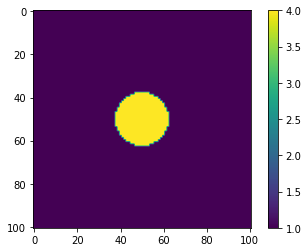

In [17]:
Nz = 210
Npml = np.array([20,20,0])
L0 = 1e-6
## specify slab plane
xrange = yrange = np.array([-0.5,0.5])
zrange = [-1,1];
radius = 0.125
Nx = Ny = 101

N = np.array([Nx,Ny,Nz])

x = np.linspace(xrange[0], xrange[1], Nx)
y = np.linspace(yrange[0], yrange[1], Ny)
z = np.linspace(zrange[0], zrange[1], Nz)
xx,yy = np.meshgrid(x,y)

slab_plane = 1*np.ones((Nx,Ny))

slab_plane[xx**2+yy**2<radius**2] = 4
plt.imshow(slab_plane)
plt.colorbar()

wvlen = 0.51


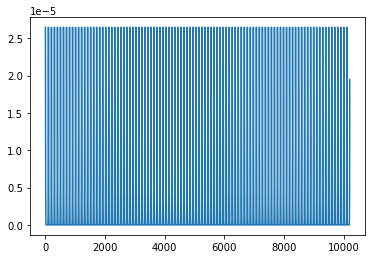

In [39]:
omega = 2*np.pi*C0/(wvlen*L0);
dx = np.diff(xrange)/Nx
dy = np.diff(yrange)/Ny
Sxfi, Sxbi, Syfi, Sybi, Szfi,_ = S_create_3D(omega, [dx, dy, 1],
                                          [Nx, Ny, 1],
                                          [Npml[0], Npml[1],0], 
                                          EPS0, ETA0) 

plt.plot(np.imag(Sxfi.diagonal()))

## mode solve the slab_plane

In [19]:
print(L0, xrange, yrange)

1e-06 [-0.5  0.5] [-0.5  0.5]


In [20]:
A = eigen_slice_kz(L0, wvlen, xrange, yrange, slab_plane, [10,10])


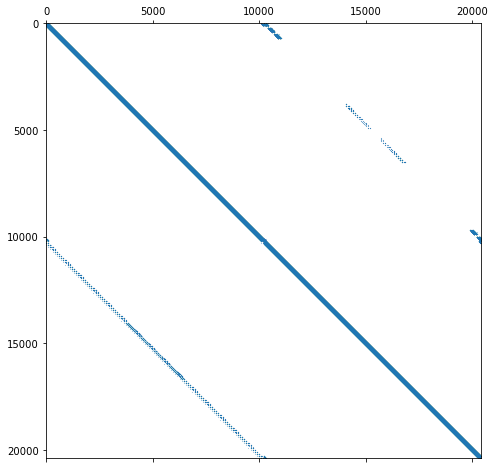

In [21]:
plt.figure(figsize = (8,8))
plt.spy(A, markersize = 0.1)

In [22]:
print(A[0:10, 0:10])

  (0, 0)	(166.03665550941875-0.5667132321738979j)
  (0, 1)	(-2.7341301627906858+0.08980205459500815j)
  (1, 1)	(166.702476107787-0.5819781793587233j)
  (1, 0)	(-3.6381493098017796+0.13790523078292055j)
  (1, 2)	(-4.9103571894548725+0.21636566319787404j)
  (2, 2)	(174.27719020373527-1.1486172036818882j)
  (2, 1)	(-6.732083910911325+0.3476012907579601j)
  (2, 3)	(-9.391136684293611+0.5733086275459995j)
  (3, 3)	(190.91560307410586-2.910418091957235j)
  (3, 2)	(-13.355466013421397+0.9737045842042016j)
  (3, 4)	(-19.40616745215412+1.709006222375105j)
  (4, 4)	(231.2033818677009-9.253639309990792j)
  (4, 3)	(-28.88459944808693+3.112850059897772j)
  (4, 5)	(-44.16481281108364+5.913081964715093j)
  (5, 5)	(340.99572753045743-36.79474457456307j)
  (5, 4)	(-69.57972017797383+11.781813940779617j)
  (5, 6)	(-113.26203774395331+24.785223348405516j)
  (6, 6)	(679.9294434369676-188.16064076282117j)
  (6, 5)	(-190.73294561286787+55.428725392257824j)
  (6, 7)	(-331.04252821556946+132.5042080851854j)
 

## specify a target sigma
Don't use 'LM', 'SM' options

## for the kz eigensolver, we are solving kz

## Also, the outputed eigenmodes are hx,hy, we need ex, ey

In [29]:
%%time
kz_guess = 2*np.pi/wvlen
eigenvals, eigenvecs = sp.linalg.eigs(A, k = 10, sigma = 10*kz_guess**2)

CPU times: user 5min 40s, sys: 12.4 s, total: 5min 53s
Wall time: 46.8 s


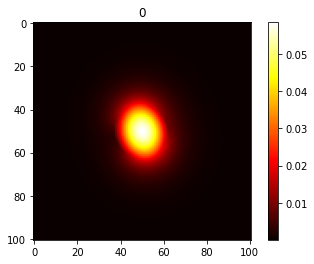

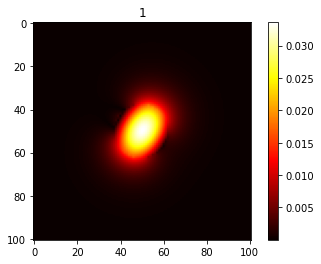

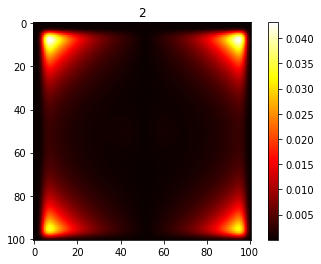

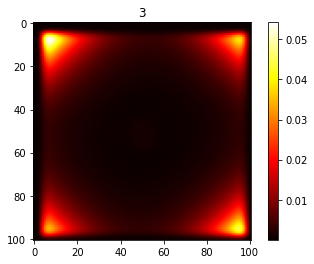

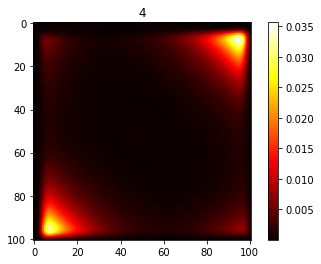

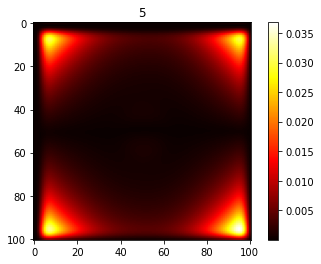

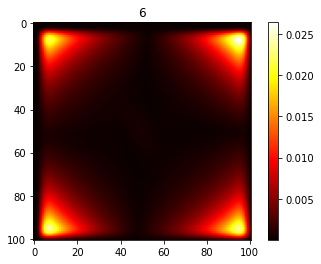

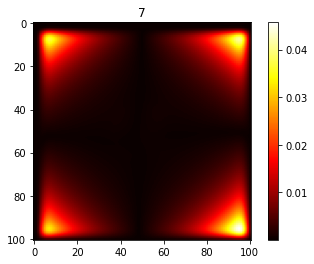

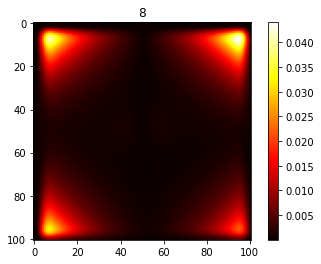

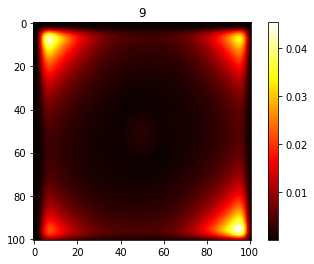

In [31]:
for i in range(eigenvecs.shape[-1]):
    mode_field = np.reshape(eigenvecs[:,i][0:Nx*Ny], (Nx,Ny), order = 'F')
    #plt.imshow(np.real(mode_field), cmap = 'RdBu')
    #plt.clim(-0.5e-1, 0.5e-1)
    plt.imshow(np.abs(mode_field), cmap = 'hot')
    plt.title(i)
    plt.colorbar()
    plt.show()

In [32]:
print(eigenvals, 2*np.pi/wvlen)

[354.83578016-9.04473145e-05j 354.11813324-1.26330019e-04j
 227.71402679-1.55435970e+02j 223.36867765-1.39085655e+02j
 223.30801447-1.38567187e+02j 221.40125707-1.00976150e+02j
 219.79647796-1.05861426e+02j 219.54495301-1.06141233e+02j
 218.98115866-1.09865656e+02j 217.34679172-9.17479098e+01j] 12.319971190548207


In [33]:
## integrate slab structure into 3D grid
eps_r = np.ones((Nx,Ny,Nz))
N = [Nx,Ny,Nz]

In [34]:
print(eps_r.shape)
for k in range(0,Nz):
    eps_r[:,:,k] = slab_plane

(101, 101, 210)


## use one of the modes as an excitation source for the waveguide

In [40]:
Jz = np.zeros(N).astype('complex'); 
Jy = np.zeros(N).astype('complex'); 
Jx = np.zeros(N).astype('complex'); 
M = Nx*Ny
Jx[:,:,35] = np.reshape(eigenvecs[0:M,0],(Nx,Ny));


eps_r_tensor_dict = {
    'eps_xx': eps_r,
    'eps_yy': eps_r.copy(),
    'eps_zz': eps_r.copy(),
}
JCurrentVector = {
    'Jx': Jx,
    'Jy': Jy,
    'Jz': Jz
}


In [41]:
%%time
print(wvlen)
print(L0, xrange, yrange, zrange)

A,b, Ch = fd3d.curlcurlE(L0, 
                         wvlen, 
                         xrange, 
                         yrange, 
                         zrange, 
                         eps_r_tensor_dict, 
                         JCurrentVector,Npml, 
                         s = -1
                        )

0.51
1e-06 [-0.5  0.5] [-0.5  0.5] [-1, 1]
(6426630,)
CPU times: user 20.3 s, sys: 9.98 s, total: 30.3 s
Wall time: 31.4 s


In [42]:
%%time
x, info = bicgstab(A,b, maxiter = 2000);
print(info)

2000
CPU times: user 2h 18min 23s, sys: 2min 23s, total: 2h 20min 46s
Wall time: 21min 46s


In [50]:
y = Ch@x

In [51]:
M = np.prod(N);
Ex = x[0:M].reshape(N, order = 'F');
Ey = x[M:2*M].reshape(N, order = 'F')
Ez = x[2*M:].reshape(N, order = 'F')

Hx =  y[0:M].reshape(N, order = 'F')
Hy =  y[M:2*M].reshape(N, order = 'F')
Hz =  y[2*M:].reshape(N, order = 'F')


/var/folders/f8/nqg1jnk548j7c367bl0lgl0r0000gn/T/ipykernel_53398/3622417741.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


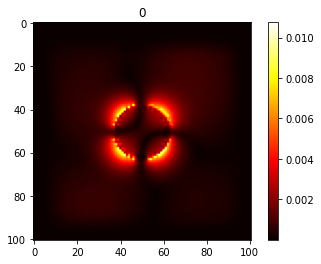

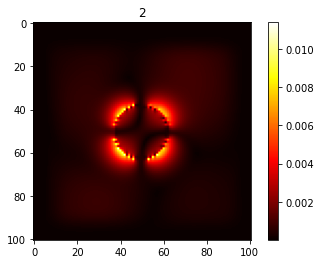

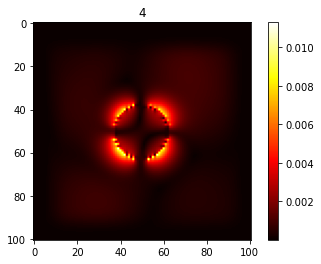

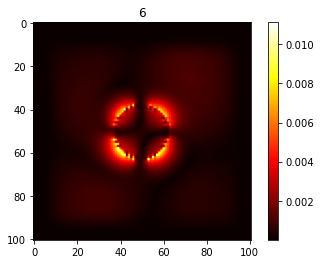

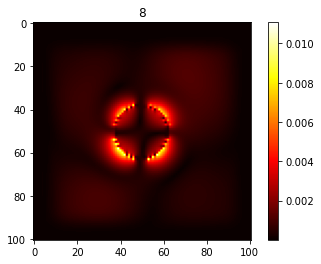

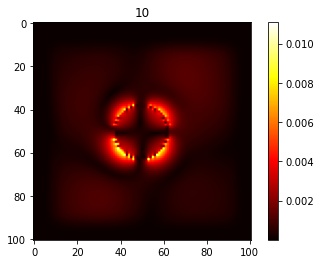

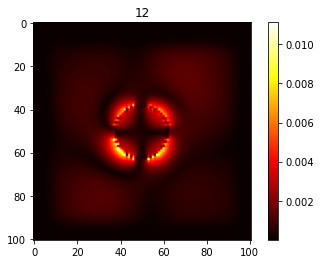

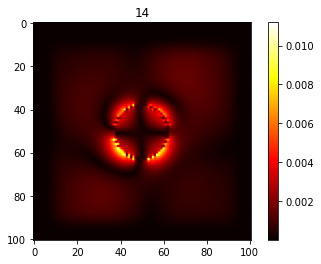

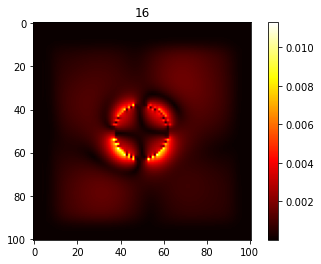

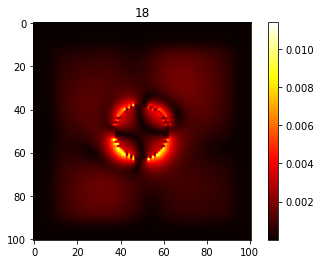

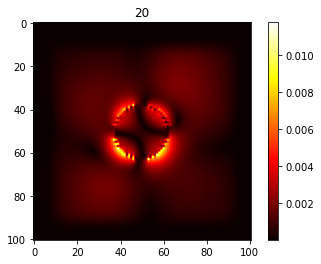

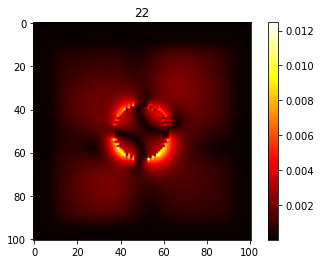

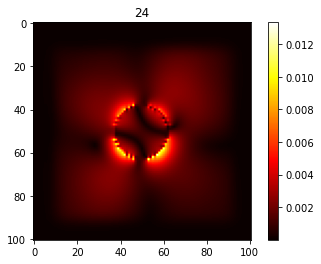

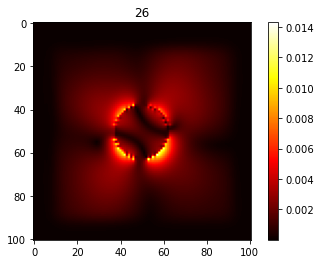

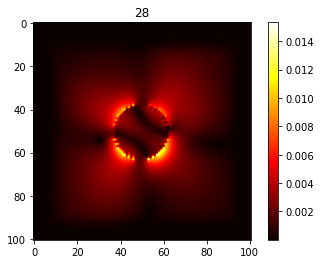

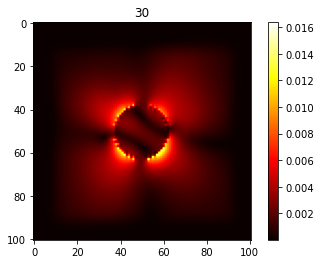

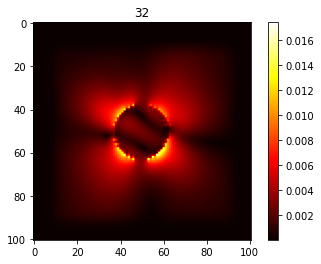

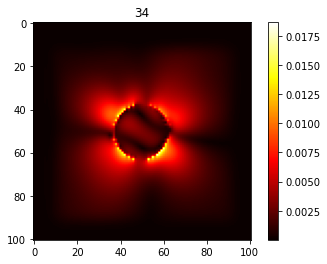

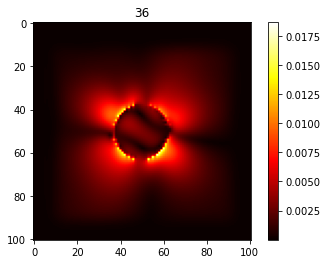

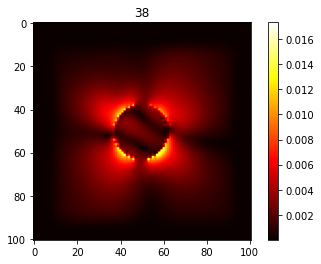

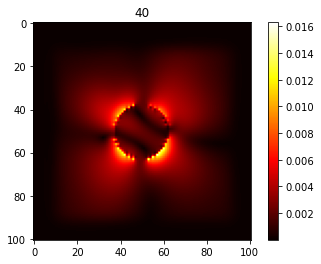

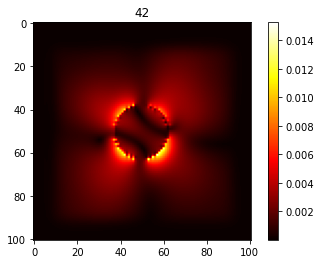

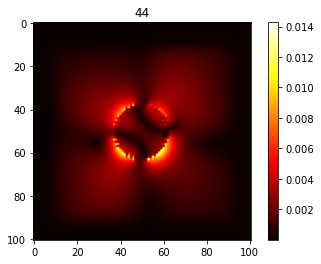

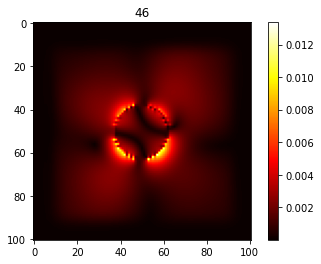

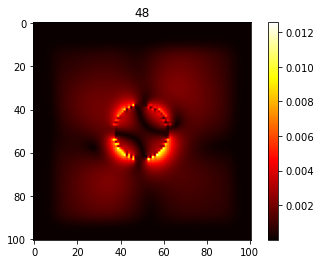

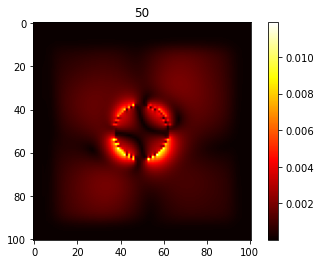

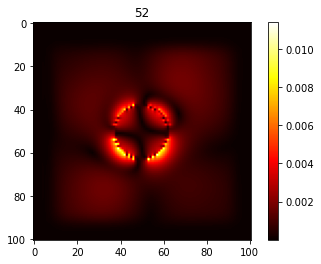

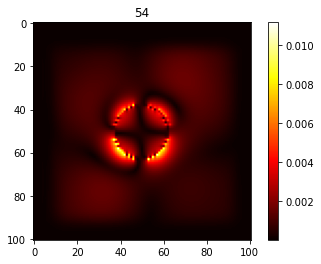

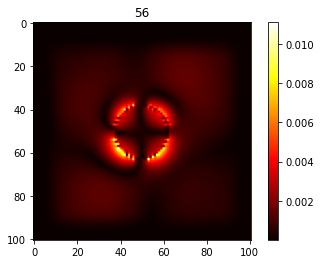

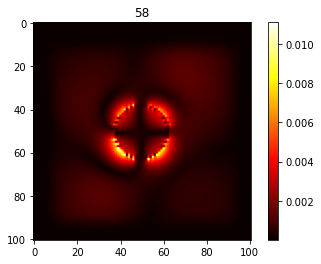

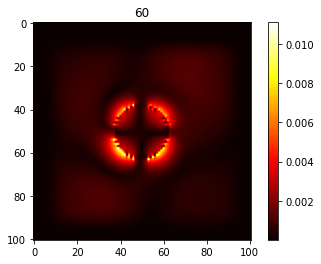

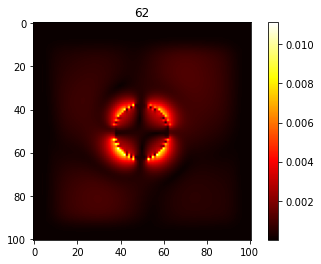

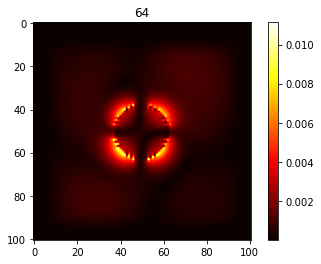

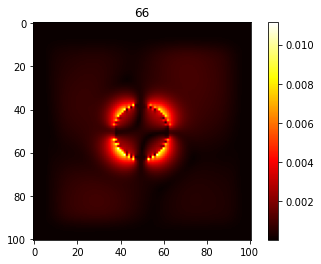

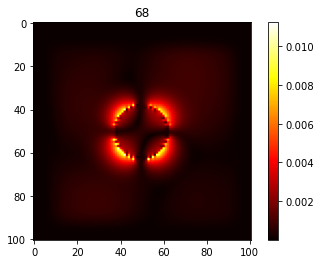

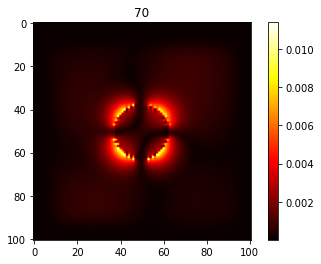

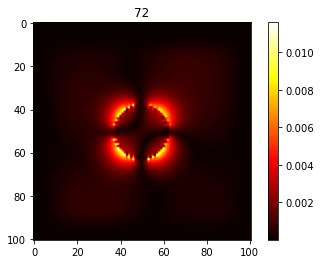

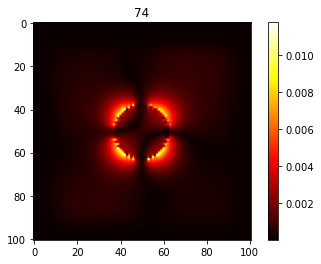

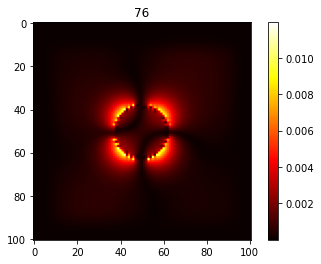

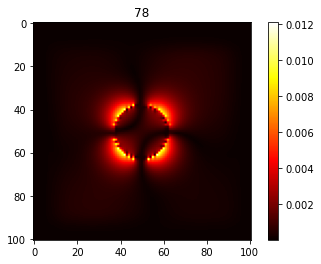

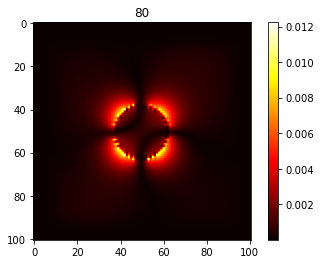

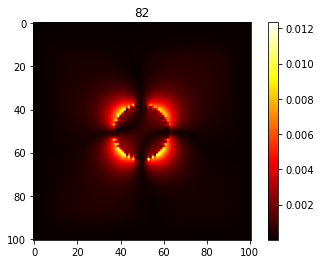

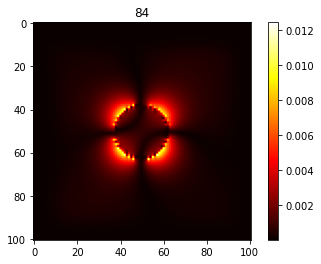

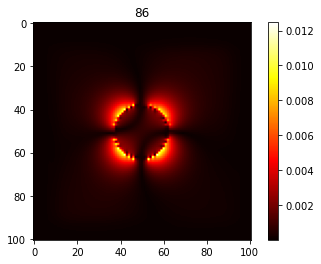

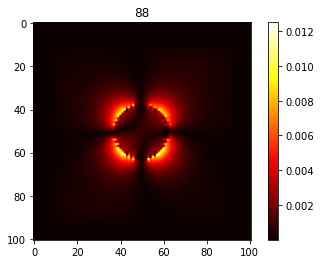

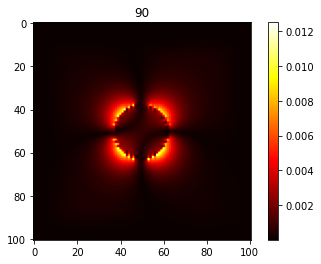

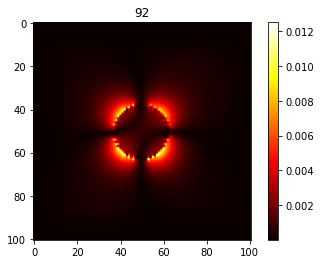

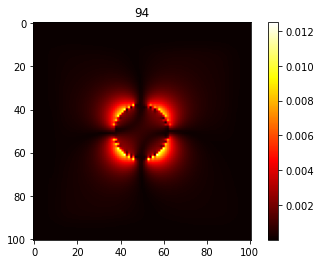

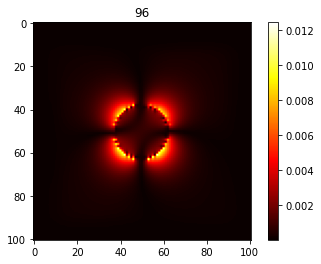

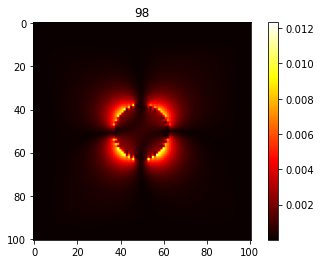

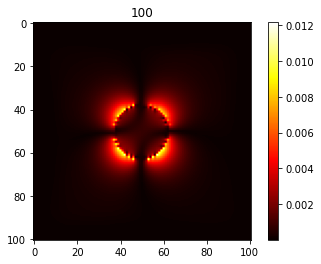

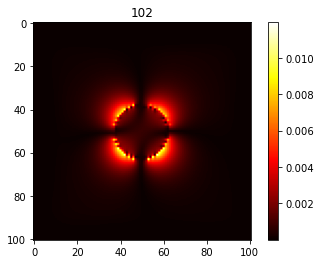

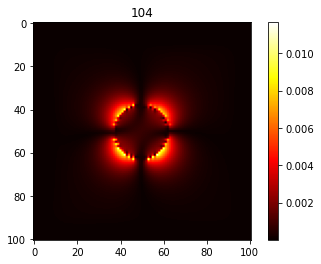

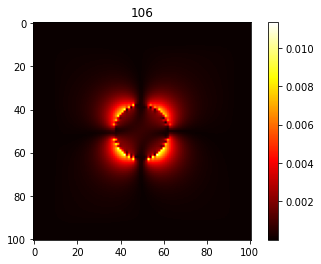

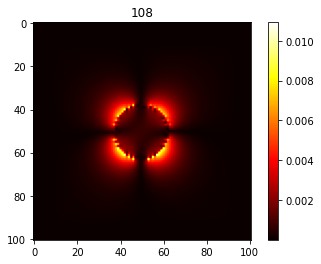

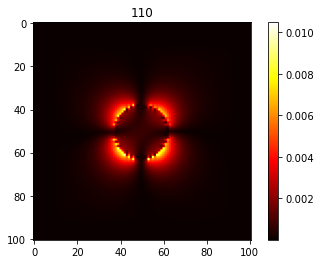

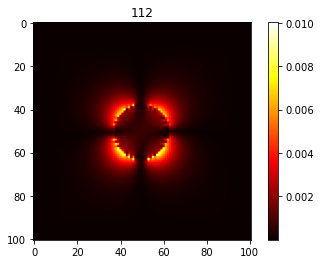

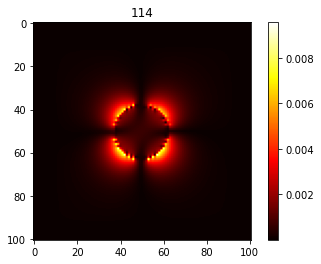

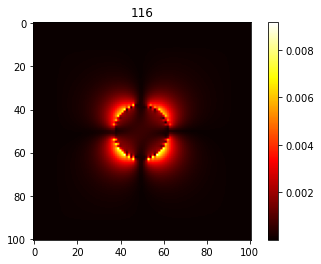

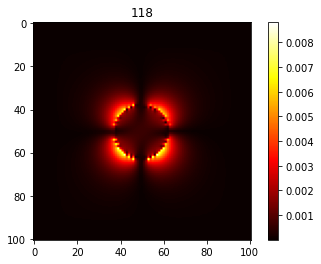

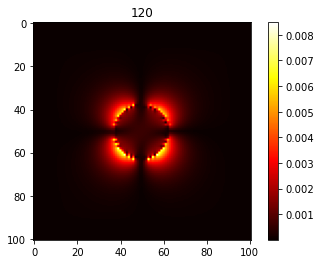

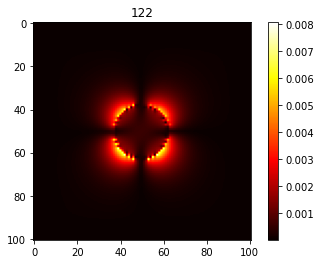

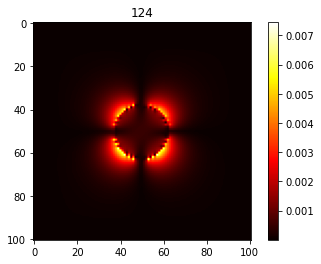

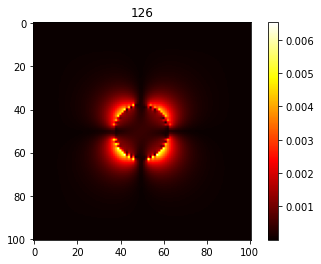

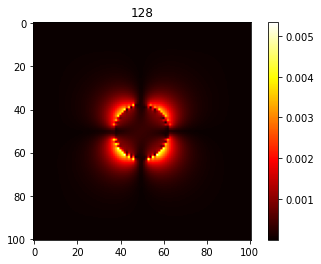

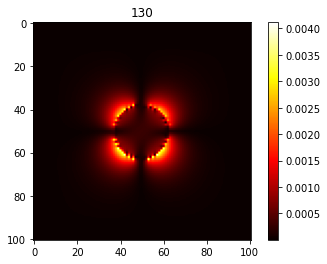

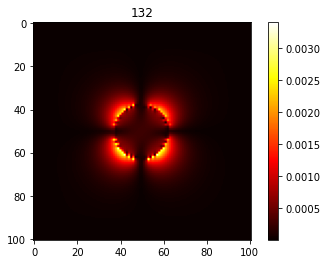

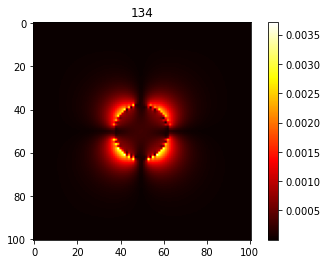

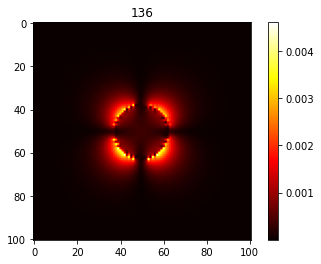

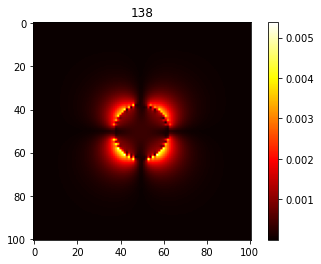

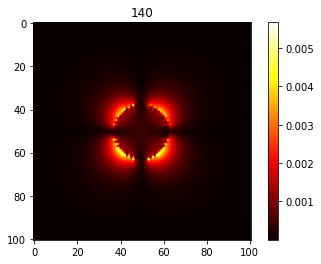

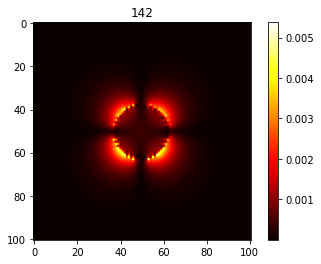

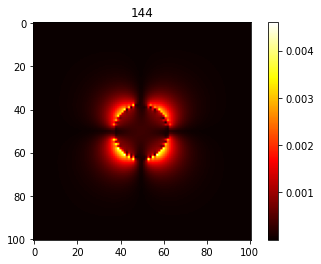

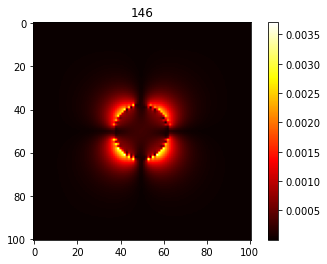

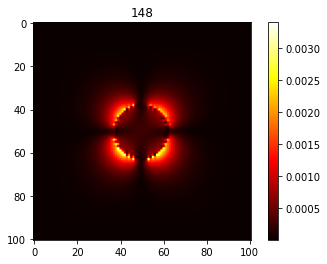

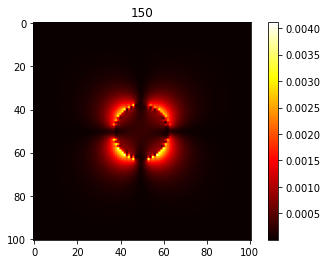

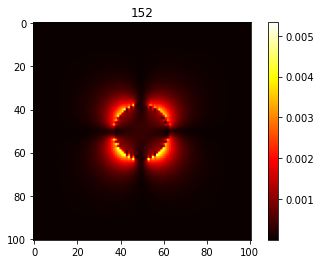

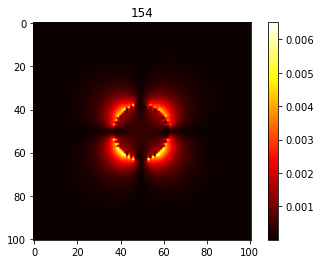

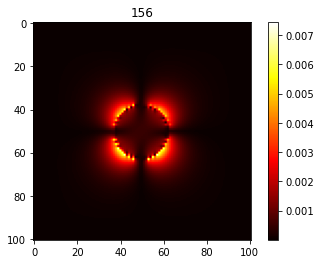

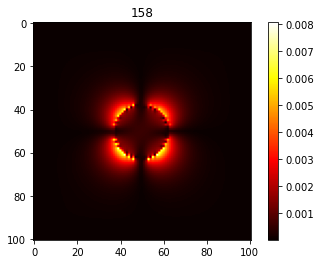

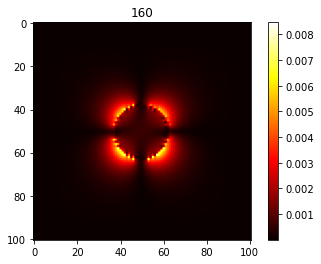

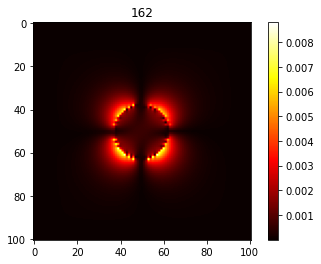

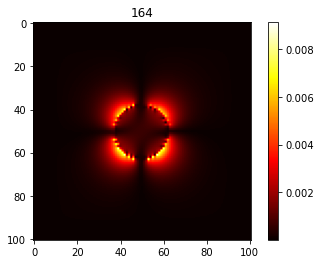

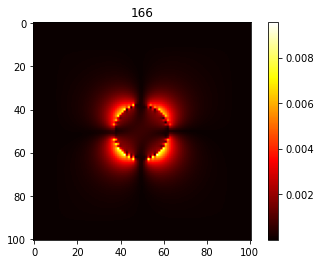

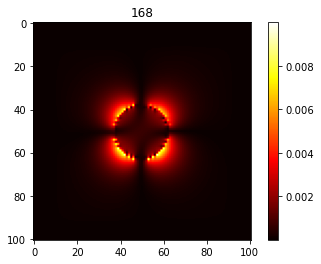

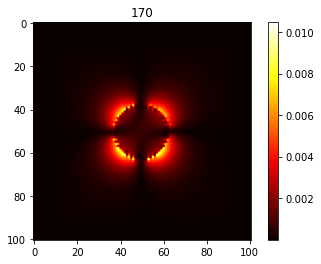

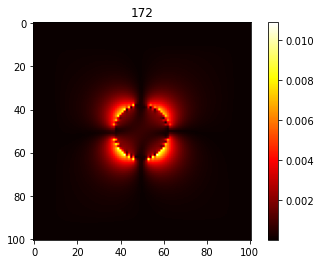

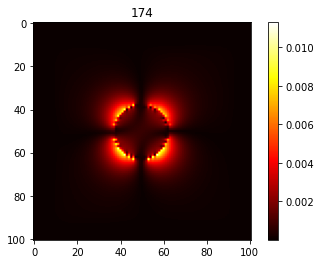

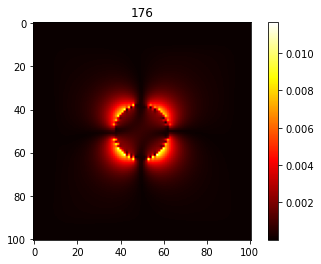

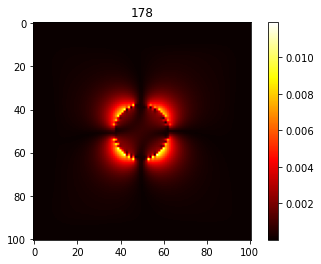

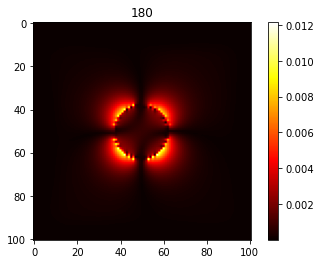

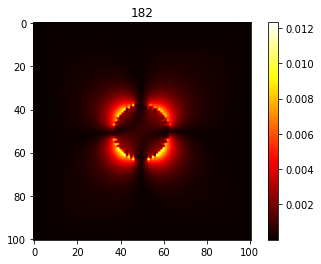

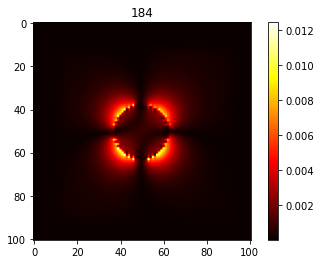

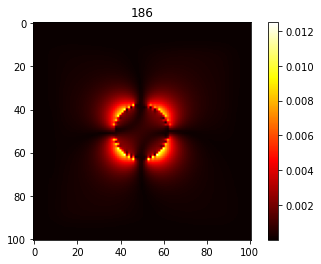

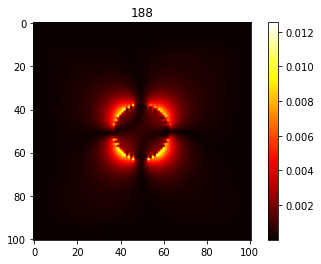

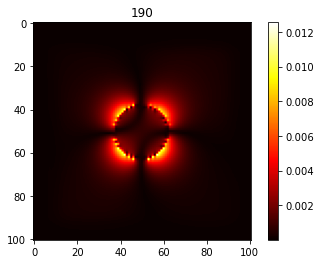

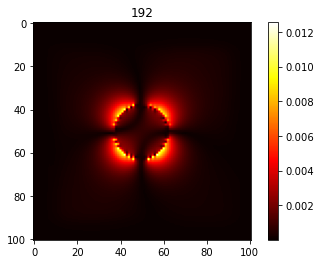

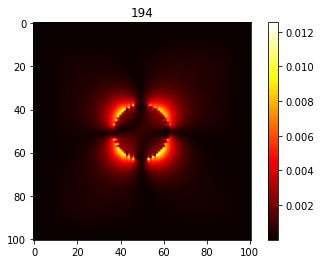

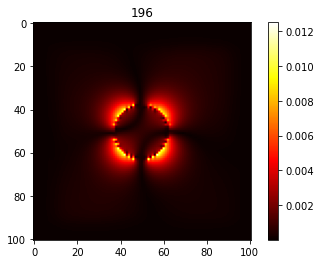

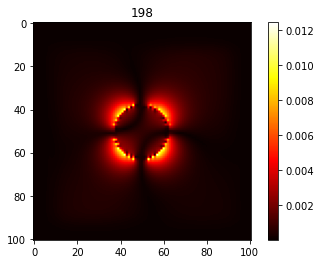

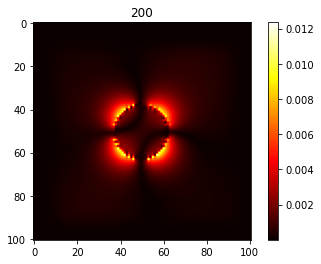

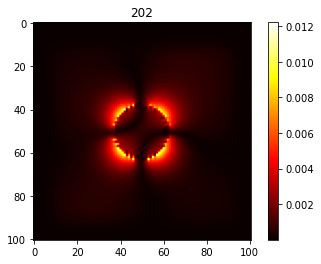

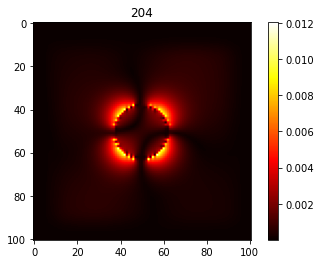

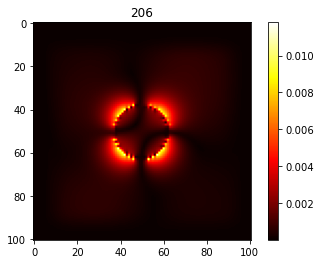

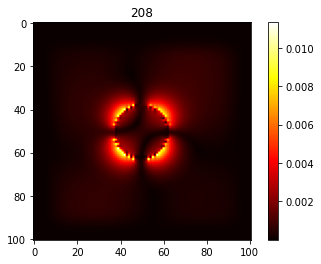

In [44]:
for i in range(0,N[-1],2):
    plt.figure()
    plt.imshow(np.abs(Ey[:,:,i]), cmap = 'hot')
    #plt.clim(0,0.5e-2)
    plt.title(i)
    plt.colorbar()

/var/folders/f8/nqg1jnk548j7c367bl0lgl0r0000gn/T/ipykernel_53398/1988954056.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


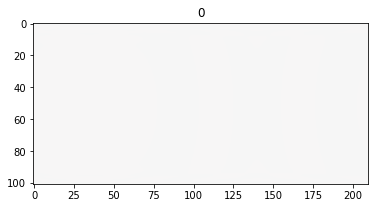

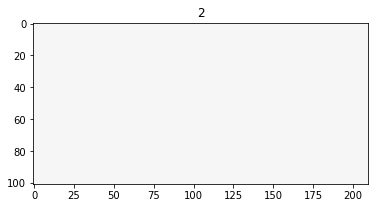

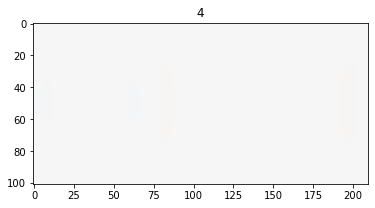

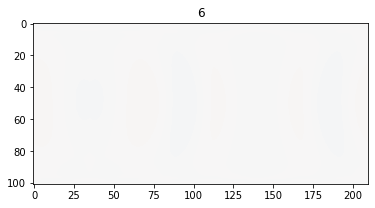

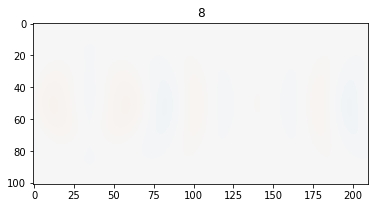

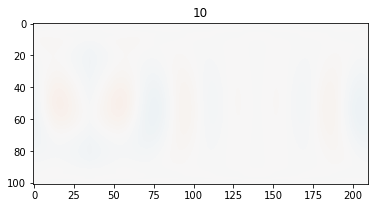

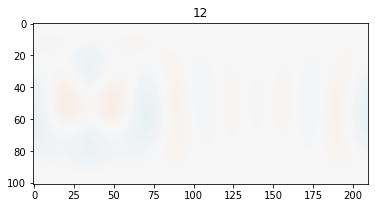

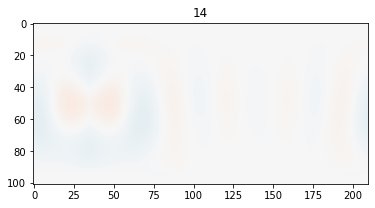

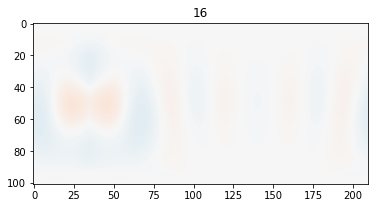

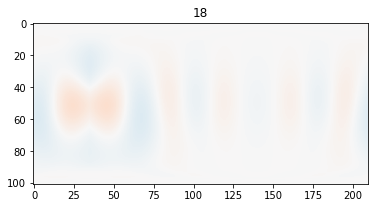

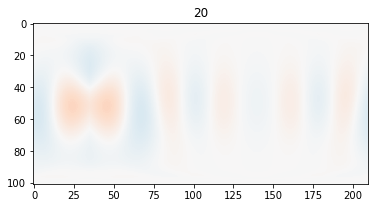

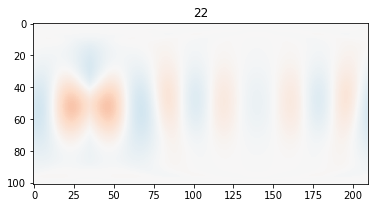

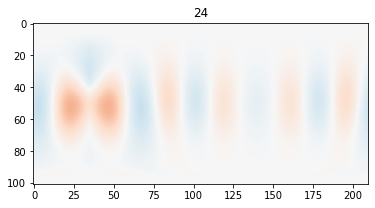

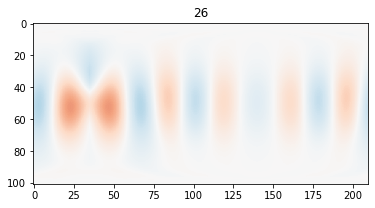

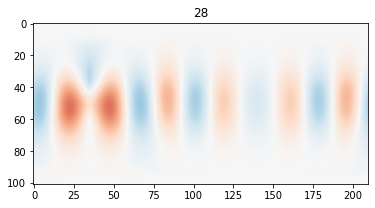

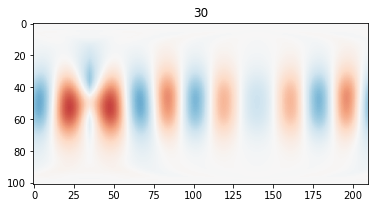

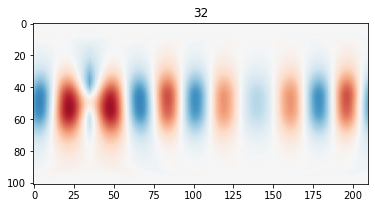

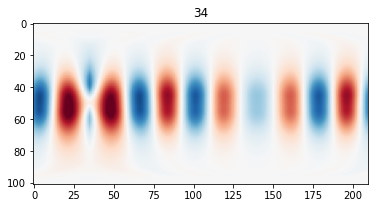

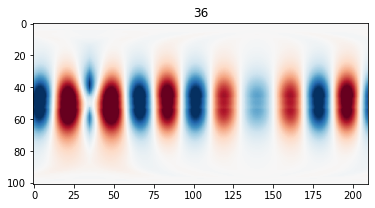

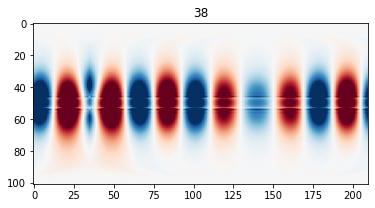

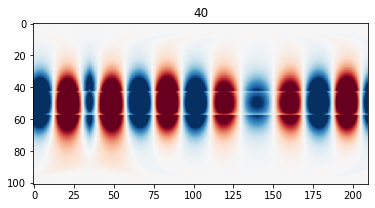

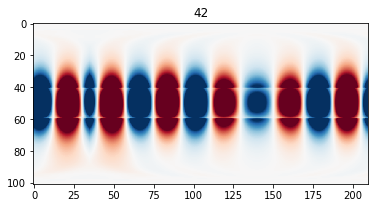

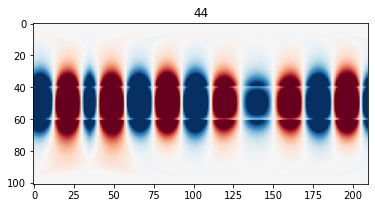

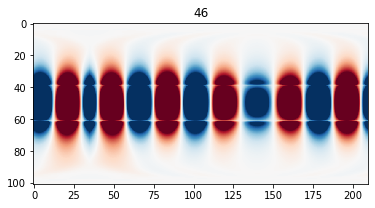

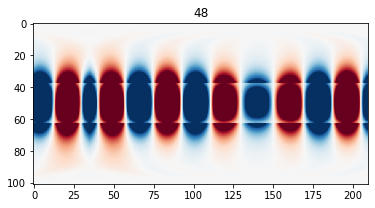

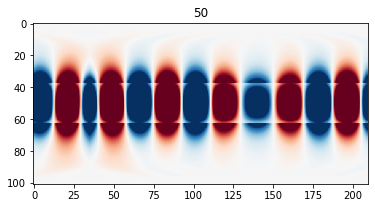

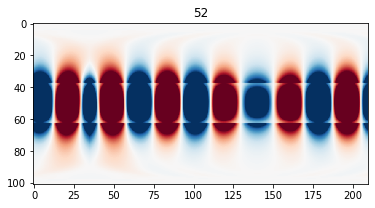

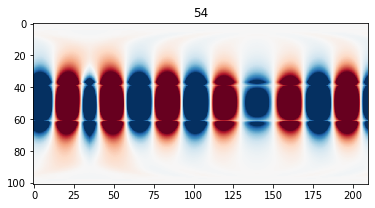

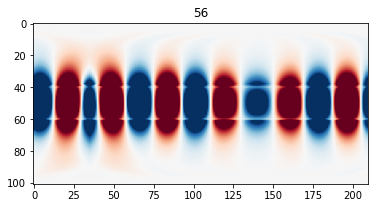

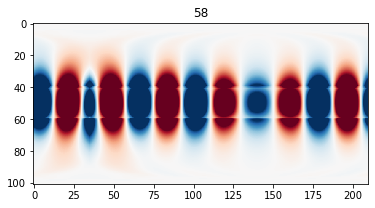

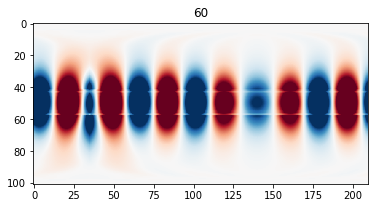

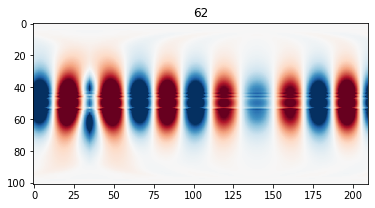

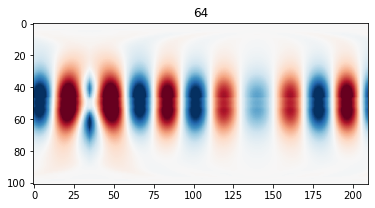

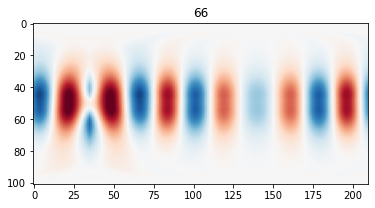

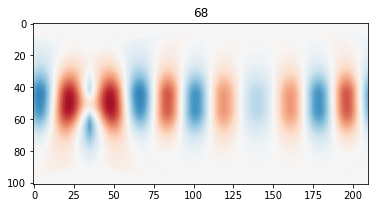

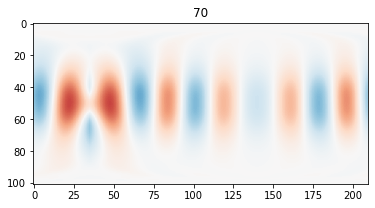

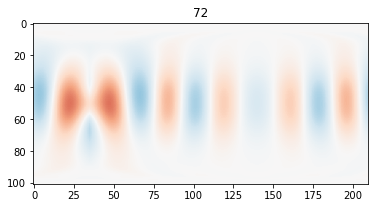

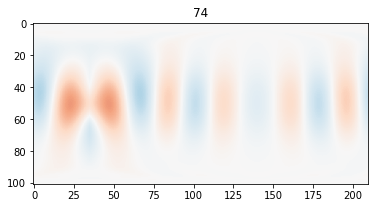

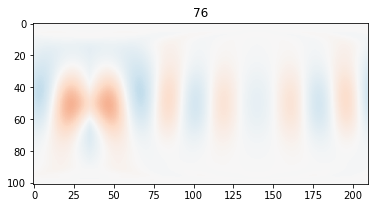

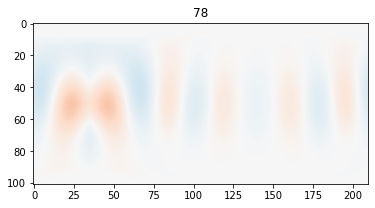

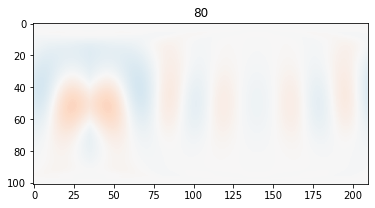

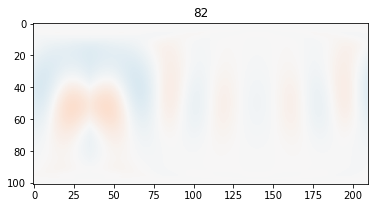

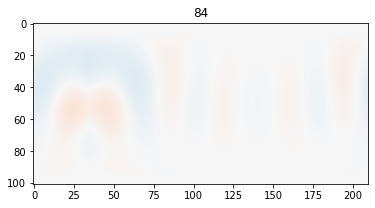

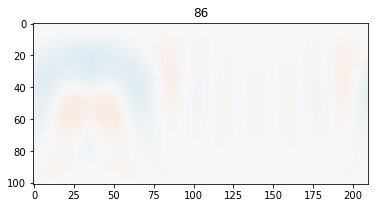

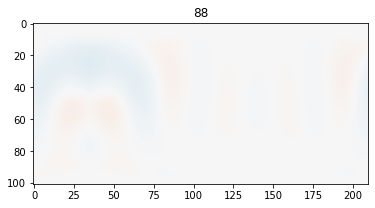

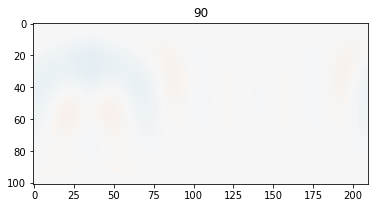

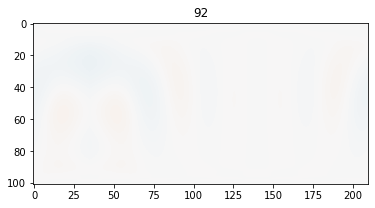

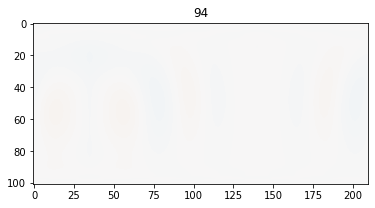

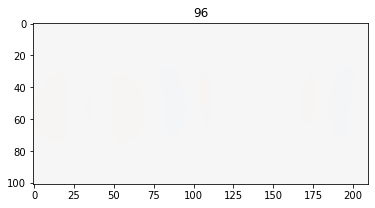

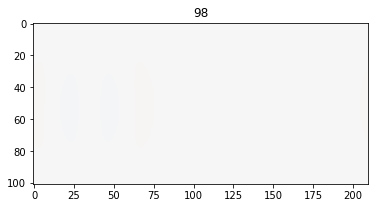

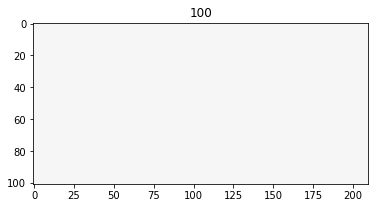

In [46]:
for i in range(0,N[0],2):
    plt.figure()
    ax = plt.subplot(111)
    plt.imshow(np.real(Ex[:,i,:]), cmap = 'RdBu')
    plt.clim(-1e-2, 1e-2)
    ax.set_aspect('equal')
    #plt.imshow(np.real(Ex[:,i,:]), cmap = 'RdBu')
    #plt.clim(-0.1e-2,0.1e-2)
    plt.title(i)
    #plt.colorbar()
#     if(i == 50):
#         plt.savefig('../img/3d_waveguide_abs_slice.png',dpi =300)
    

## subplot figure

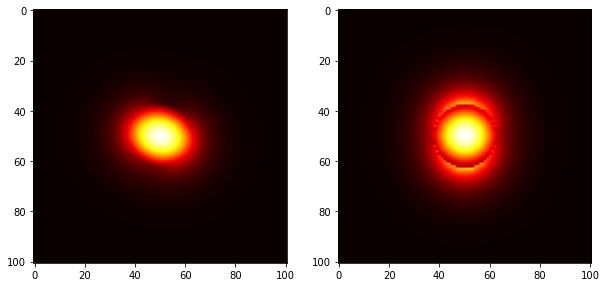

In [64]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.imshow(np.abs(np.reshape(eigenvecs[0:Nx*Ny,0], (Nx,Ny))), cmap = 'hot')
plt.subplot(122)
plt.imshow(np.abs(Ex[:,:,140]), cmap = 'hot')

